In [34]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
from graphviz import Digraph

In [36]:
# code to display a network
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    layer_colors = ["#FFCCCC", "#CCFFCC", "#CCCCFF", "#FFCC99", "#99CCFF"]
    
    def get_color(node):
        if node._op == '+': return layer_colors[0]
        elif node._op == '*': return layer_colors[1]
        elif node._op == 'tanh': return layer_colors[2]
        # Ajoutez d'autres conditions ici pour d'autres opérations ou couches
        return layer_colors[-1]  # Couleur par défaut
    
    for n in nodes:
        color = get_color(n)
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record', style='filled', fillcolor=color)
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [37]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), _op='+')
    
    def _backward(): # ex. 4
      self.grad = 1.0 * out.grad # BUG
      other.grad = 1.0 * self.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward(): # ex. 4
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other): # ex. 6
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other # TODO: ex.1 

  def __truediv__(self, other): # self / other
    return self * other**-1 # TODO: ex.1 

  def __neg__(self): # -self
    return self * -1 # TODO: ex.1 

  def __sub__(self, other): # self - other
    return self + (-other) # TODO: ex.1 

  def __radd__(self, other): # other + self
    return self + other # TODO: ex.1 

  def tanh(self): # TODO ex.3
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward(): # ex. 4
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
    
  def relu(self):
    eps = .1
    t = self.data if self.data > 0 else self.data * eps
    out = Value(t, (self,), 'relu')

    def _backward():
      self.grad += out.grad if self.data > 0 else eps * out.grad
    out._backward = _backward
    return out
  
  def exp(self): # ex.6
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward
    
    return out
    
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [38]:
# Exercise 1: fill in the Value class to enable the following function. You should get -8.0 as a result.
def lol():

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    return L

print(lol().data)

-8.0


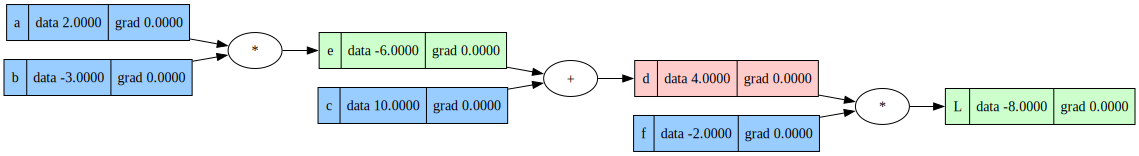

In [39]:
draw_dot(lol())

In [40]:
# Exercise 2: use the lol_grad() function below to manually compute dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db
def lol_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    d += h
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)

In [41]:
# report the values for dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db in this cell
# dL/df = 4.0
# dL/dd = 2.0
# dL/de = ...
# etc.
lol_grad()


-1.9999999999953388


In [42]:
# Exercise 3: implement the function tanh() in the Value class and build the following network
# input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1z2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



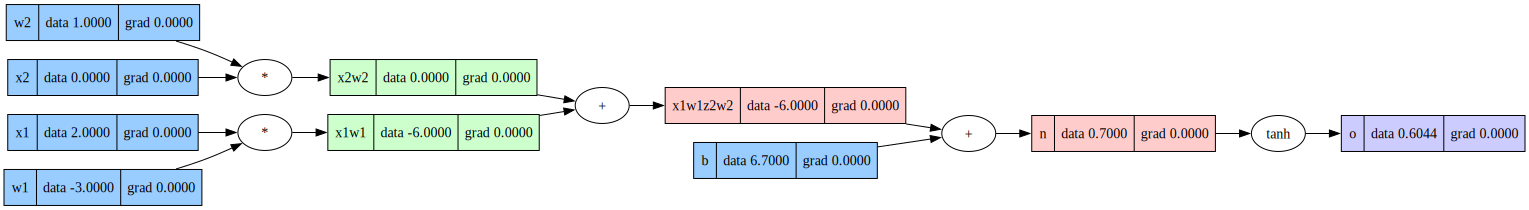

In [43]:
# o.data should be 0.6044
draw_dot(o)

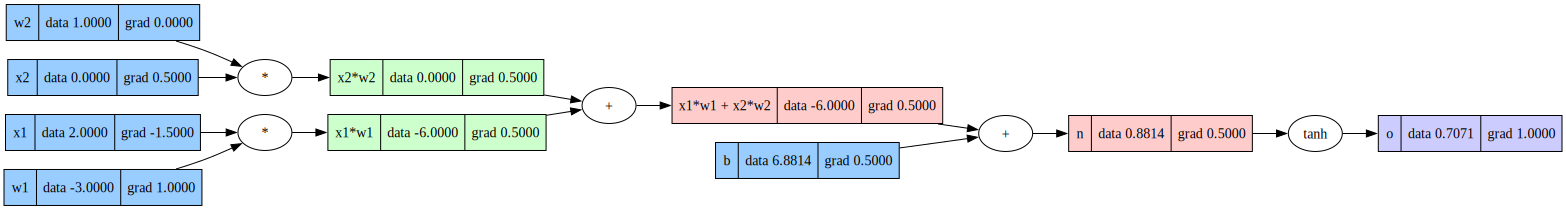

In [44]:
# Exercise 4: impement the exp() and pow() functions in the Value class. Then implement the backward() function in each Value's operator: __add__, __mul__, __tanh__
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
#e = (2*n).exp()
#o = (e - 1) / (e + 1)
o = n.tanh()
# ----
o.label = 'o'
o.backward()
draw_dot(o)

 # expected results:
 # o.data should be 0.7071
 # w1.grad = 1.0
 # w2.grad = 0.0
 # x1.grad = -1.5
 # x2.grad = 0.5

In [45]:
# Exercise 5: why are we using self.grad += and not self.grad = in the backward() functions?  Answer as a comment in this cell. Hint: create a Value "a" and then b = a + a.

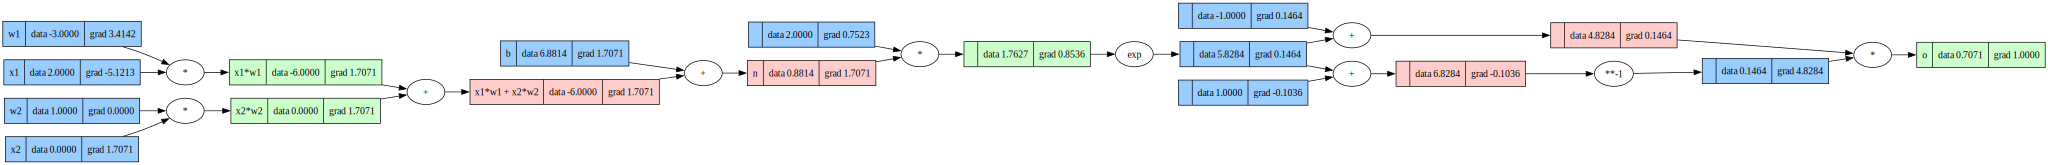

In [46]:
# Exercise 6: replace the tanh() function by a combination of exp() and division.  Implement the __exp__ and __pow__ functions in Value. You should get the same results as before.
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
#o = ... (no tanh allowed)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [47]:
# Congratulations!  You "unlocked" the basic layer of pytorch.  Now you know what happens under the hood of the following code. Check that you get the same output as before for grad values.

import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [48]:
# Exercise 7: Let's build an MLP based on the Value class.  Fill in the Neuron, Layer and MLP classes.

In [49]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    # out = act.tanh()
    out = act.relu()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [50]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=2.009031376602883)

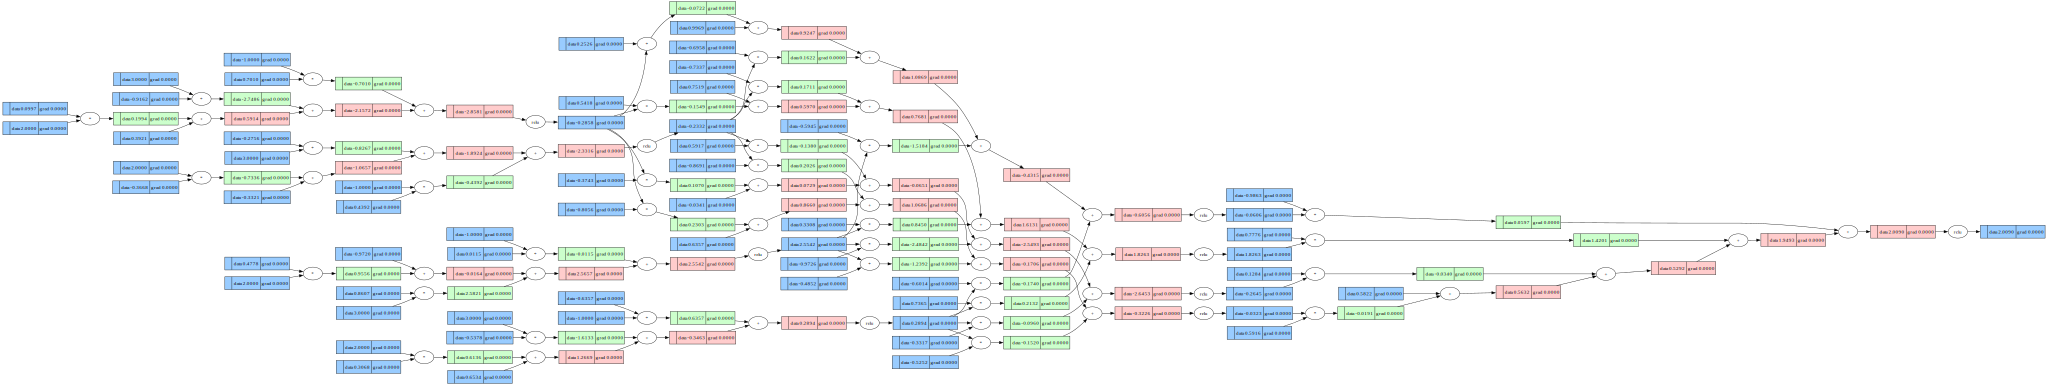

In [51]:
draw_dot(n(x))

In [52]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [53]:
len(n.parameters())

41

In [54]:
ypred = [n(x) for x in xs]
ypred

[Value(data=2.009031376602883),
 Value(data=2.444590762946799),
 Value(data=0.5474793619401477),
 Value(data=1.7429236744224814)]

In [55]:
loss = sum([(a-b)**2 for (a,b) in zip(ypred, ys)])
loss

Value(data=15.829977804795607)

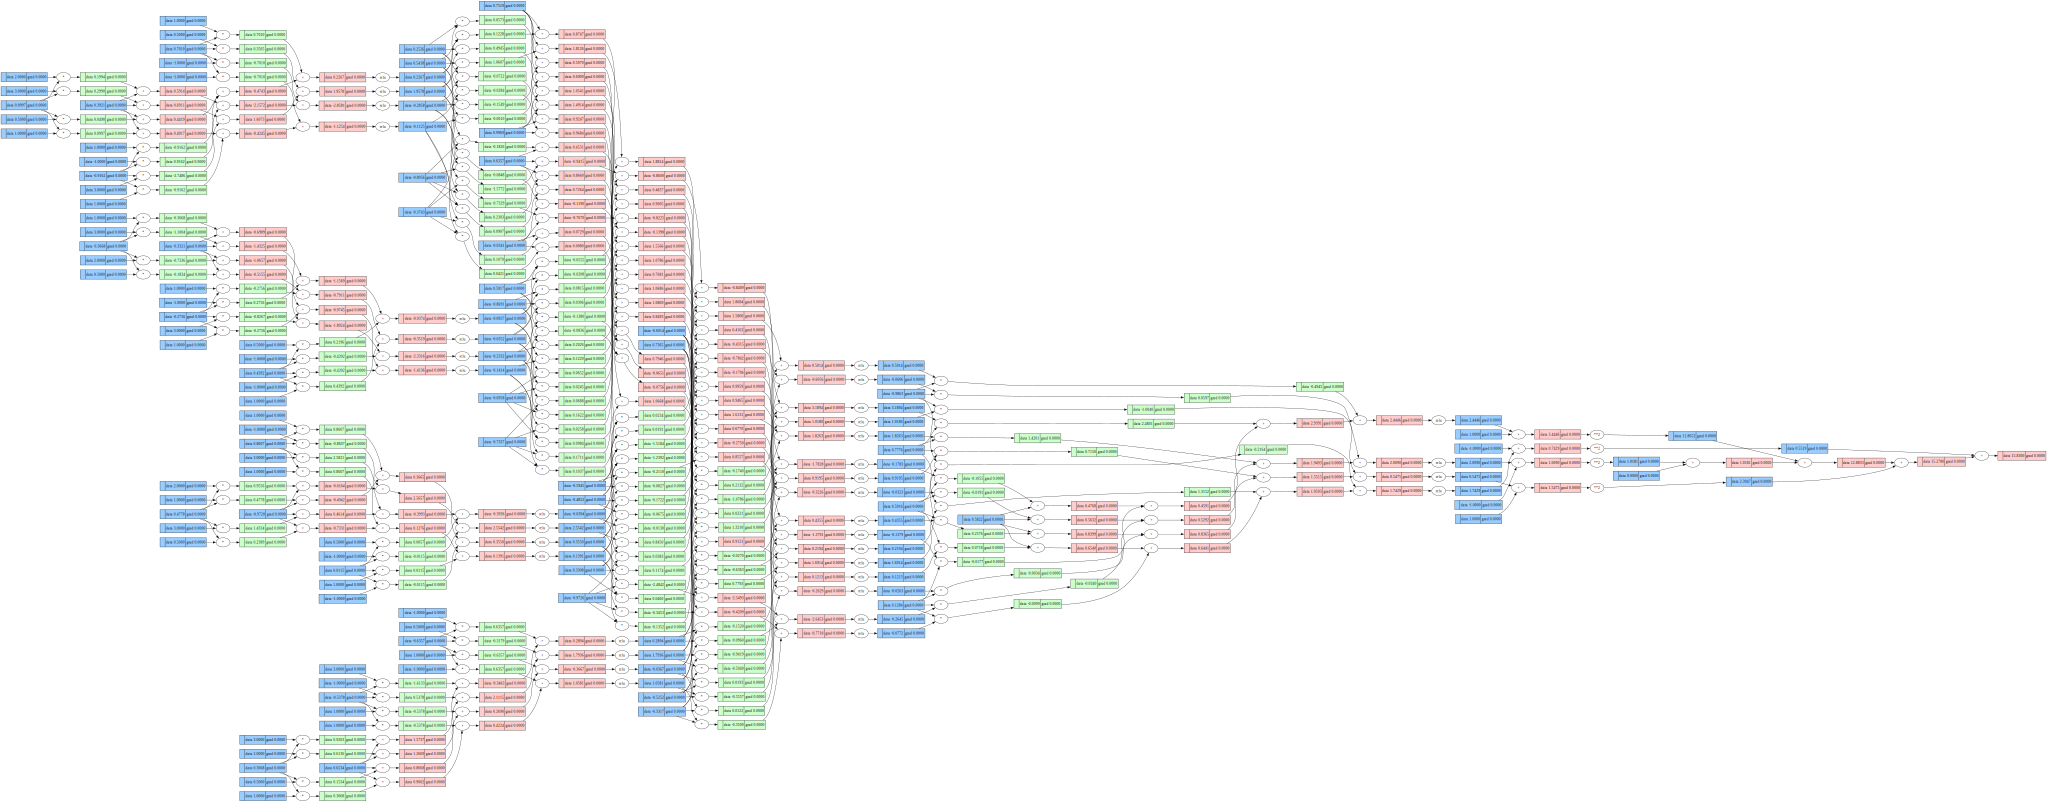

In [56]:
# see how a simple MLP can yield a complex graph already
draw_dot(loss)

In [57]:
# Exercise 8: write a training loop
for k in range(20):
    # forward pass (compute the loss)
    ypred = [n(x) for x in xs]
    loss = sum([(a-b)**2 for(a,b) in zip(ypred, ys)])
    #backward pass 
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    print(k, loss.data)

0 15.829977804795607
1 3.721184851103968
2 3.448054890395513
3 3.240843450680372
4 3.048277103094901
5 2.923388899819137
6 2.4655026691741404
7 1.402683775798565
8 1.2652753034307265
9 1.1871039459184867
10 1.1545897306086932
11 1.0406224633737935
12 1.0516088231478795
13 1.1156333794774307
14 0.49999504518793114
15 0.487860827644752
16 0.4031840983728688
17 0.33131231651942183
18 0.2699005475347887
19 0.2312815316620706


In [58]:
# Exercise 9: why do you need to reset the grads to zero at every step?  Answer as a comment in this cell.

In [59]:
# Exercise 10: try to approximate the n^2 function with a 2-layer MLP.  why is it so hard?
# Expected answers:
# - our tanh() function requires exp() which quickly goes out of bound
# - our compute graph grows quickly with the number of training examples
# - needs a lot of data
# - needs a more advanced optimizer
# - example with keras: https://stackoverflow.com/questions/55170460/neural-network-for-square-x2-approximation

In [60]:
num = 100
xs = [[a/num] for a in range(-num, num)]
ys = [b[0]**2 for b in xs]
n = MLP(1,[8,8,1])
len(n.parameters())

97

In [ ]:
for k in range(200):
    # forward pass (compute the loss)
    ypred = [n(x) for x in xs]
    loss = sum([(a-b)**2 for(a,b) in zip(ypred, ys)])
    #backward pass 
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    # update
    for p in n.parameters():
        p.data += -0.001 * p.grad
    print(k, loss.data)

0 23.920854952645445
1 23.573455834918352
2 23.281703113165413
3 23.02623095277648
4 22.796557430955996
5 22.57876807563979
6 22.368824666909497
7 22.162129121453493
8 21.95476522553509
9 21.74693345140453
10 21.533244767802692
11 21.31513427373879
12 21.089573355895467
13 20.856654826283545
14 20.61574636655849
15 20.36502019686916
16 20.106612312558255
17 19.838916602724304
18 19.56211303030179
19 19.275530300100304
20 18.979524564212852
21 18.67448119057994
22 18.360480928690148
23 18.039668972058838
24 17.711320047204897
25 17.376245783253847
26 17.03577245039462
27 16.692979075281613
28 16.351501499270984
29 16.03840228212325
30 15.74401725772637
31 15.459219394652342
32 15.181527370937886
33 14.91221541399357
34 14.651204132664525
35 14.398597581867364
36 14.154882479323074
37 13.918296421249613
38 13.69197817167936
39 13.473103202389183
40 13.263671461689107
41 13.0609044339229
42 12.86317709549547
43 12.670336768951778
44 12.480682600250974
45 12.294361963750989
46 12.111117479

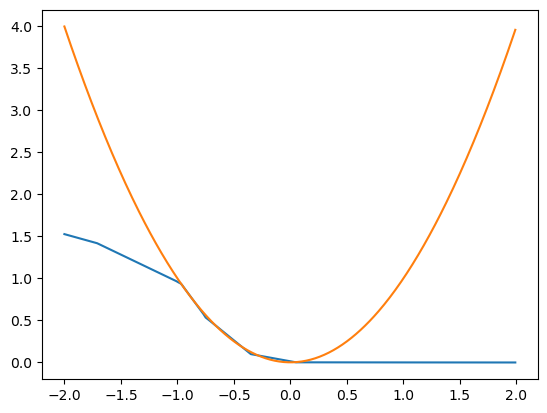

In [29]:
xs = [a/100 for a in range(-200,200)]
ys = [n([x]).data for x in xs]
yg = [x**2 for x in xs]
plt.plot(xs, ys)
plt.plot(xs, yg)
plt.show()